# Imports

In [1]:
import argparse
from collections import defaultdict
import os
import os.path as osp

import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

from utils.config import config

In [2]:
args = argparse.Namespace(
    random_state=24,
)

# Load data

In [3]:
df_path = osp.join(config.data_dir, "task1", "bioresponse.csv")
df = pd.read_csv(df_path)

print(f"Shape of the loaded dataframe: {df.shape}")
df.head()

Shape of the loaded dataframe: (3751, 1777)


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


# A little bit of EDA

In the first 100 variables there are 

1. several binary variables, 
2. several variables with skewed histogram
3. several categorical variables with 1-5 values in one of the categories

... then my browser said "good bye", but I'm sure that using binary and categorical variables in stratification, applying log-transformations, and filtering almost constant variables would make classification results better...

In [ ]:
profile = ProfileReport(df, title="Bioresponse profile report", minimal=True)
profile.to_file("EDA.html")

# Cross-validation scheme - train_test_split

In [4]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=args.random_state, stratify=df["Activity"])

# Train classifiers and get predictions

In [5]:
params = {
    "small": {
        "max_depth": 8,
        "random_state": args.random_state
    },
    "deep": {
        "max_depth": 15,
        "random_state": args.random_state
    }
}

classifiers = {}
probas = {}
exp_names = []

for classifier_name, classifier_class in zip(("tree", "rf"), (DecisionTreeClassifier, RandomForestClassifier)):
    for depth, param_dict in params.items():
        exp_name = f"{classifier_name}_{depth}"
        print(f"Fitting {exp_name}...")
        clf = classifier_class(**param_dict)
        clf.fit(df_train.drop(columns="Activity"), df_train["Activity"])
        
        classifiers[exp_name] = clf
        probas[exp_name] = clf.predict_proba(df_test.drop(columns="Activity"))[:, 1]
        exp_names.append(exp_name)

Fitting tree_small...
Fitting tree_deep...
Fitting rf_small...
Fitting rf_deep...


In [6]:
probas["gt"] = df_test["Activity"].values
df_res = pd.DataFrame(probas)
print(f"Results dataframe shape {df_res.shape}")
df_res.head()

Results dataframe shape (751, 5)


,tree_small,tree_deep,rf_small,rf_deep,gt
0,0.877855,0.881250,0.699225,0.717755,1
1,0.877855,0.881250,0.751900,0.810257,1
2,0.369668,0.180000,0.366612,0.337236,0
3,0.174330,0.012658,0.271849,0.268645,0
4,0.877855,0.953125,0.783464,0.753867,1


# Calculate metrics

## Table with metrics

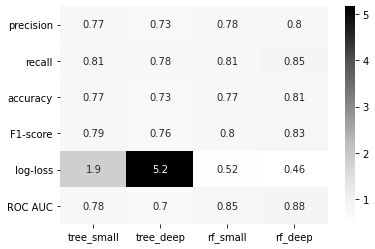

In [7]:
metrics_dict = defaultdict(dict)

for exp_name in exp_names:
    preds = (df_res[exp_name] > 0.5).astype(np.int)
    prec, rec, fscore, _ = metrics.precision_recall_fscore_support(df_res["gt"], preds, average="binary")
    acc = metrics.accuracy_score(df_res["gt"], preds)
    ll = metrics.log_loss(df_res["gt"], df_res[exp_name])
    roc_auc = metrics.roc_auc_score(df_res["gt"], df_res[exp_name])
    
    for metric_name, metric_value in zip(
        ("precision", "recall", "accuracy", "F1-score", "log-loss", "ROC AUC"),
        (prec, rec, acc, fscore, ll, roc_auc)
    ):
        metrics_dict[exp_name][metric_name] = metric_value
        
df_metr = pd.DataFrame(metrics_dict)
sns.heatmap(df_metr, annot=True, cmap="Greys");

Deep tree classifier overfitted, while random forest based on deep trees didn't.

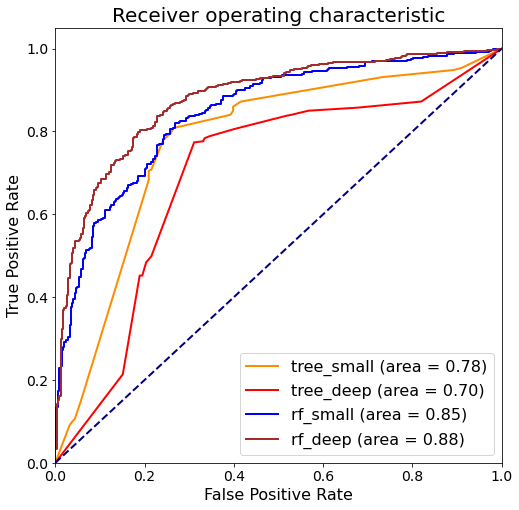

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))

for exp_name, col in zip(exp_names,("darkorange", "red", "blue", "brown")):
    fpr, tpr, _ = metrics.roc_curve(df_res["gt"], df_res[exp_name])
    roc_auc = metrics.roc_auc_score(df_res["gt"], df_res[exp_name])
    plt.plot(fpr, tpr, color=col,
         lw=2, label=f"{exp_name} (area = {roc_auc:.2f})")
    
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
  
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("Receiver operating characteristic", fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

# Minimizing the false negatives

We should create such a classifier that has minimum of false negatives. Several metrics based on confusion matrix operate with FNs, two of them are recall and NPV (negative predictive value). We will try to find such a threshold that recall is > 0.9, and accuracy is as high as possible.

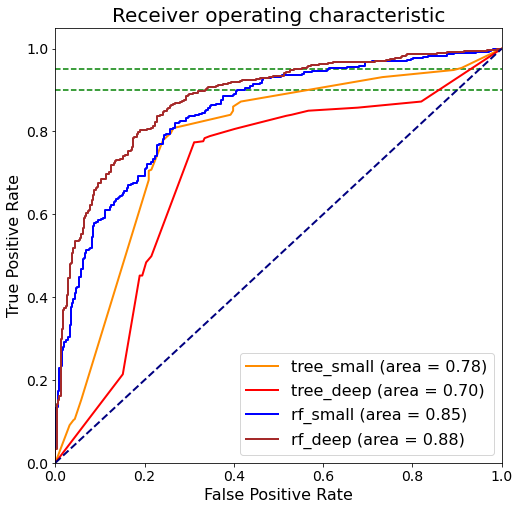

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))

for exp_name, col in zip(exp_names,("darkorange", "red", "blue", "brown")):
    fpr, tpr, _ = metrics.roc_curve(df_res["gt"], df_res[exp_name])
    roc_auc = metrics.roc_auc_score(df_res["gt"], df_res[exp_name])
    plt.plot(fpr, tpr, color=col,
         lw=2, label=f"{exp_name} (area = {roc_auc:.2f})")
    
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.hlines([0.9, 0.95], 0, 1, color="green", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
  
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("Receiver operating characteristic", fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [10]:
def find_threshold(gt, proba, min_recall=0.9):
    metr_list = []
    for thr in np.unique(proba):
        pred = proba >= thr
        rec = metrics.recall_score(gt, pred)
        acc = metrics.accuracy_score(gt, pred)
        metr_list.append({"thr": thr, "recall": rec, "accuracy": acc})
        
    df = pd.DataFrame(metr_list)
    df_f = df[df["recall"] > min_recall]
    if df_f.shape[0] == 0:
        print(f"Recall of {min_recall} cannot be achieved")
        best_idx = df["recall"].idxmax()
    else:
        best_idx = df_f["accuracy"].idxmax()
    
    return df.loc[best_idx, "thr"]

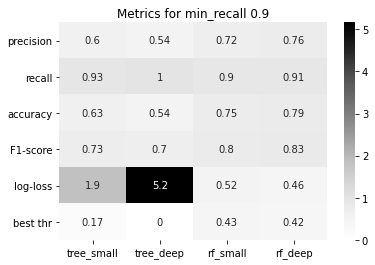

In [11]:
metrics_dict = defaultdict(dict)

for exp_name in exp_names:
    best_thr = find_threshold(df_res["gt"], df_res[exp_name])
    preds = df_res[exp_name] >= best_thr
    prec, rec, fscore, _ = metrics.precision_recall_fscore_support(df_res["gt"], preds, average="binary")
    acc = metrics.accuracy_score(df_res["gt"], preds)
    ll = metrics.log_loss(df_res["gt"], df_res[exp_name])
    
    for metric_name, metric_value in zip(
        ("precision", "recall", "accuracy", "F1-score", "log-loss", "best thr"),
        (prec, rec, acc, fscore, ll, best_thr)
    ):
        metrics_dict[exp_name][metric_name] = metric_value
        
df_metr = pd.DataFrame(metrics_dict)
fig, ax = plt.subplots()
sns.heatmap(df_metr, annot=True, cmap="Greys", ax=ax)
ax.set_title("Metrics for min_recall 0.9");

The best classifier which can achieve the highest accuracy given that the recall should be higher that 0.9 is Random Forest with deep trees. The threshold is lower than 0.5, as expected.

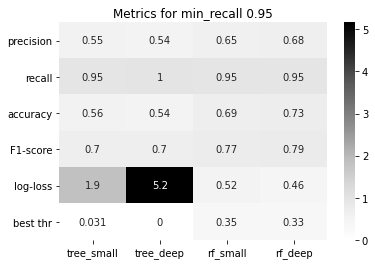

In [12]:
metrics_dict = defaultdict(dict)

for exp_name in exp_names:
    best_thr = find_threshold(df_res["gt"], df_res[exp_name], min_recall=0.95)
    preds = df_res[exp_name] >= best_thr
    prec, rec, fscore, _ = metrics.precision_recall_fscore_support(df_res["gt"], preds, average="binary")
    acc = metrics.accuracy_score(df_res["gt"], preds)
    ll = metrics.log_loss(df_res["gt"], df_res[exp_name])
    
    for metric_name, metric_value in zip(
        ("precision", "recall", "accuracy", "F1-score", "log-loss", "best thr"),
        (prec, rec, acc, fscore, ll, best_thr)
    ):
        metrics_dict[exp_name][metric_name] = metric_value
        
df_metr = pd.DataFrame(metrics_dict)
fig, ax = plt.subplots()
sns.heatmap(df_metr, annot=True, cmap="Greys", ax=ax)
ax.set_title("Metrics for min_recall 0.95");